In [1]:
%load_ext autoreload
%autoreload 2

from deep_bf.data_handler import DataLoader
import torch
import numpy as np
from tqdm import tqdm
import os

#urls = "/home/panda/rf_data/dataset/webdataset/dataset-{000..005}.tar"
base_url = "/home/panda/rf_data/dataset/webdataset"

samples_idx_path = "/home/panda/rf_data/dataset/samples_idx"

dl = DataLoader("/home/panda/rf_data/")
df = dl.get_df()

nc = 128
ns = 2300

nz = 2048
nx = 256

seed = 42
batch_size = 1

device = "cuda"
dtype = torch.float32

In [2]:
from deep_bf.dataset import GlobalSamplesIdx
gsi = GlobalSamplesIdx()

print(gsi.samples_idx.shape)

loading gsi
gsi loaded
torch.Size([11, 128, 2048, 256])


In [3]:
from deep_bf.dataset import get_datasets

train, val = get_datasets(base_url, seed, batch_size)
it = iter(train)

In [5]:
from deep_bf.models import DAS

sample = next(it)
model = DAS(gsi).to("cuda")
rfs, ids, _, _ = sample
rfs = rfs.to(device="cuda")
ids = ids.to(device="cuda")

i = 12
for _ in range(i):
    sample = next(it)

output = model(rfs, ids)
#print(output.shape)

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from deep_bf.models import DAS

class Toy(nn.Module):
    def __init__(self, gsi, device="cuda", dtype=torch.float32):
        super().__init__()
        self.device = device
        self.dtype = dtype

        self.conv1 = nn.Conv2d(1, 16, (5, 3), padding="same")
        self.conv2 = nn.Conv2d(16, 8, (5, 3), padding="same")
        self.conv3 = nn.Conv2d(8, 8, (5, 3), padding="same")
        self.conv4 = nn.Conv2d(8, 4, (5, 3), padding="same")
        self.conv5 = nn.Conv2d(4, 2, (5, 3), padding="same")
        self.conv6 = nn.Conv2d(2, 1, (7, 5), padding="same")
        self.activation = nn.LeakyReLU(negative_slope=0.01)
        self.das = DAS(gsi, device=device, dtype=dtype)

    def forward(self, rfs, ids):
        x = rfs.to(device=self.device, dtype=self.dtype)
       
        x = self.conv1(x)
        x = self.activation(x)
        x = self.conv2(x)
        x = self.activation(x)
        x = self.das(x, ids)
        x = self.conv3(x)
        x = self.activation(x)
        x = self.conv4(x)
        x = self.activation(x)
        x = self.conv5(x)
        x = self.activation(x)
        x = self.conv6(x)
        x = self.activation(x)
        return x


model = Toy(gsi).to("cuda")

ckpt = torch.load("./best_model_server.pth")
model.load_state_dict(ckpt["model_state_dict"])
#print(output.shape)


<All keys matched successfully>

In [8]:
i = 12
for _ in range(i):
    sample = next(it)

In [9]:
rfs, ids, _, _ = sample
rfs = rfs.to(device="cuda")
ids = ids.to(device="cuda")

output = model(rfs, ids).squeeze(1)

In [11]:
import torch.optim as optim

n_epoch = 50
optimizer = optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.MSELoss()

best_val_loss = float("inf")

for epoch in range(n_epoch):
    model.train()
    train_loss = 0.0

    for sample in train:
        rfs, ids, targets, _ = sample
        optimizer.zero_grad()
        outputs = model(rfs, ids).squeeze(1)
        loss = criterion(outputs, targets.to(device=model.device, dtype=model.dtype))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for sample in val:
            rfs, ids, targets, _ = sample
            outputs = model(rfs, ids).squeeze(1)
            loss = criterion(outputs, targets.to(device=model.device, dtype=model.dtype))
            val_loss += loss.item()
    
    avg_train = train_loss / len(train)
    avg_val = val_loss / len(val)

    print(f"Epoch {epoch+1}/{n_epoch} -> Train Loss: {avg_train:.6f} | Val Loss: {avg_val:.6f}")

    if avg_val < best_val_loss:
        best_val_loss = avg_val
        torch.save({
            'epoch': n_epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': best_val_loss,
        }, './best_model.pth')
        print("¡Modelo guardado!")

KeyboardInterrupt: 

TSH332


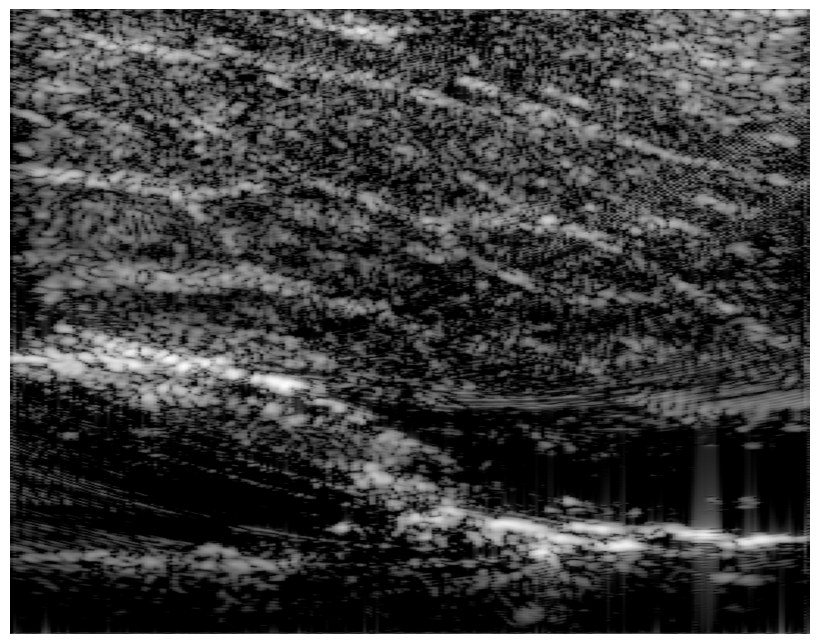

In [10]:
import matplotlib.pyplot as plt
from deep_bf.beamformers import compute_meshgrid, get_rf_bmode

# TODO: Sacar el zlims, xlims con el samples_idx

idx = 0
with torch.no_grad():
    _o = output[idx].squeeze().cpu()
name = sample[-1][idx]
print(name)

pw = dl.get_defined_pwdata(name, "RF")
Z, X = compute_meshgrid(pw, nz, nx)

Z = Z.cpu()
X = X.cpu()

zlims = np.array([Z[0, 0], Z[-1, 0]]) * 1e3
xlims = np.array([X[0, 0], X[0, -1]]) * 1e3

vmin = -60
vmax = 0

fig = plt.figure(figsize=(8, 10), frameon=False)
ax = fig.add_axes([0, 0, 1, 1])

b_mode = get_rf_bmode(_o, vmin, vmax)
extent = (xlims[0], xlims[-1], zlims[-1], zlims[0])

ax.imshow(b_mode, cmap='gray', vmin=vmin, vmax=vmax,
          extent=extent,
          aspect='equal')
ax.set_axis_off()
plt.show()